In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM


2025-05-01 18:18:35.262 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=None)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [ ]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "aerodactyl"
start_epoch=1
num_epochs=80
save_every=5
backup_every=20

# Model Hyper-parameters
head_layers=3
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=1

# Training Hyper-parameters
batch_size=128
lr=1e-3
momentum=0.9
weight_decay=5e-4
T_max=16
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
optimizer = SGD(
    model.parameters(), 
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
    )
scheduler = CosineAnnealingLR(
    optimizer=optimizer, 
    T_max=T_max, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 20
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 27, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: aerodactyl



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 1/80 (1.25%) Completed
	📊 Training Loss: 2.0751
	✅ Training Accuracy: 47.70%
	⏳ Elapsed Time: 86.49s | ETA: 6832.93s
	🕒 Completed At: 18:20


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1861
	🎯 Validation Accuracy: 65.42%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 2/80 (2.50%) Completed
	📊 Training Loss: 1.0279
	✅ Training Accuracy: 69.98%
	⏳ Elapsed Time: 86.24s | ETA: 6726.85s
	🕒 Completed At: 18:21


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0003
	🎯 Validation Accuracy: 70.39%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 3/80 (3.75%) Completed
	📊 Training Loss: 0.7754
	✅ Training Accuracy: 76.71%
	⏳ Elapsed Time: 85.76s | ETA: 6603.31s
	🕒 Completed At: 18:23


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9289
	🎯 Validation Accuracy: 72.46%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 4/80 (5.00%) Completed
	📊 Training Loss: 0.6185
	✅ Training Accuracy: 81.15%
	⏳ Elapsed Time: 86.45s | ETA: 6570.55s
	🕒 Completed At: 18:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9001
	🎯 Validation Accuracy: 73.98%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.67batch/s]


🚀 Epoch 5/80 (6.25%) Completed
	📊 Training Loss: 0.5073
	✅ Training Accuracy: 84.13%
	⏳ Elapsed Time: 85.37s | ETA: 6403.10s
	🕒 Completed At: 18:27


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8882
	🎯 Validation Accuracy: 74.65%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 6/80 (7.50%) Completed
	📊 Training Loss: 0.3927
	✅ Training Accuracy: 87.48%
	⏳ Elapsed Time: 86.69s | ETA: 6414.94s
	🕒 Completed At: 18:28


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8645
	🎯 Validation Accuracy: 75.29%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 7/80 (8.75%) Completed
	📊 Training Loss: 0.3056
	✅ Training Accuracy: 90.39%
	⏳ Elapsed Time: 86.65s | ETA: 6325.68s
	🕒 Completed At: 18:30


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8407
	🎯 Validation Accuracy: 76.79%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 8/80 (10.00%) Completed
	📊 Training Loss: 0.2341
	✅ Training Accuracy: 92.88%
	⏳ Elapsed Time: 86.84s | ETA: 6252.73s
	🕒 Completed At: 18:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8468
	🎯 Validation Accuracy: 77.00%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 9/80 (11.25%) Completed
	📊 Training Loss: 0.1821
	✅ Training Accuracy: 94.57%
	⏳ Elapsed Time: 87.78s | ETA: 6232.39s
	🕒 Completed At: 18:34


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.85batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8275
	🎯 Validation Accuracy: 77.71%



Training progress: 100%|██████████| 313/313 [01:29<00:00,  3.48batch/s]


🚀 Epoch 10/80 (12.50%) Completed
	📊 Training Loss: 0.1397
	✅ Training Accuracy: 96.14%
	⏳ Elapsed Time: 89.91s | ETA: 6293.65s
	🕒 Completed At: 18:36


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8440
	🎯 Validation Accuracy: 77.56%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 11/80 (13.75%) Completed
	📊 Training Loss: 0.1136
	✅ Training Accuracy: 97.08%
	⏳ Elapsed Time: 86.52s | ETA: 5969.86s
	🕒 Completed At: 18:37


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8306
	🎯 Validation Accuracy: 78.37%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 12/80 (15.00%) Completed
	📊 Training Loss: 0.0952
	✅ Training Accuracy: 97.71%
	⏳ Elapsed Time: 86.31s | ETA: 5868.85s
	🕒 Completed At: 18:39


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8511
	🎯 Validation Accuracy: 78.13%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 13/80 (16.25%) Completed
	📊 Training Loss: 0.0839
	✅ Training Accuracy: 98.19%
	⏳ Elapsed Time: 86.02s | ETA: 5763.34s
	🕒 Completed At: 18:41


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8430
	🎯 Validation Accuracy: 78.20%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.53batch/s]


🚀 Epoch 14/80 (17.50%) Completed
	📊 Training Loss: 0.0758
	✅ Training Accuracy: 98.46%
	⏳ Elapsed Time: 88.63s | ETA: 5849.44s
	🕒 Completed At: 18:43


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8338
	🎯 Validation Accuracy: 78.44%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 15/80 (18.75%) Completed
	📊 Training Loss: 0.0710
	✅ Training Accuracy: 98.72%
	⏳ Elapsed Time: 87.11s | ETA: 5662.35s
	🕒 Completed At: 18:44


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8491
	🎯 Validation Accuracy: 78.14%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_15.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.55batch/s]


🚀 Epoch 16/80 (20.00%) Completed
	📊 Training Loss: 0.0681
	✅ Training Accuracy: 98.83%
	⏳ Elapsed Time: 88.09s | ETA: 5637.52s
	🕒 Completed At: 18:46


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8528
	🎯 Validation Accuracy: 78.21%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 17/80 (21.25%) Completed
	📊 Training Loss: 0.0668
	✅ Training Accuracy: 98.87%
	⏳ Elapsed Time: 86.31s | ETA: 5437.39s
	🕒 Completed At: 18:48


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8425
	🎯 Validation Accuracy: 78.23%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 18/80 (22.50%) Completed
	📊 Training Loss: 0.0685
	✅ Training Accuracy: 98.74%
	⏳ Elapsed Time: 87.78s | ETA: 5442.65s
	🕒 Completed At: 18:50


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8288
	🎯 Validation Accuracy: 78.62%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 19/80 (23.75%) Completed
	📊 Training Loss: 0.0688
	✅ Training Accuracy: 98.69%
	⏳ Elapsed Time: 85.99s | ETA: 5245.32s
	🕒 Completed At: 18:52


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.93batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8501
	🎯 Validation Accuracy: 78.27%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 20/80 (25.00%) Completed
	📊 Training Loss: 0.0683
	✅ Training Accuracy: 98.73%
	⏳ Elapsed Time: 86.96s | ETA: 5217.81s
	🕒 Completed At: 18:53


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8429
	🎯 Validation Accuracy: 78.23%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_185407_aerodactyl_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_185407_aerodactyl_BaseDino_epoch_20.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.60batch/s]


🚀 Epoch 21/80 (26.25%) Completed
	📊 Training Loss: 0.0685
	✅ Training Accuracy: 98.73%
	⏳ Elapsed Time: 87.01s | ETA: 5133.48s
	🕒 Completed At: 18:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8544
	🎯 Validation Accuracy: 78.20%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 22/80 (27.50%) Completed
	📊 Training Loss: 0.0711
	✅ Training Accuracy: 98.49%
	⏳ Elapsed Time: 86.68s | ETA: 5027.25s
	🕒 Completed At: 18:57


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8580
	🎯 Validation Accuracy: 77.83%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 23/80 (28.75%) Completed
	📊 Training Loss: 0.0743
	✅ Training Accuracy: 98.40%
	⏳ Elapsed Time: 86.37s | ETA: 4923.11s
	🕒 Completed At: 18:59


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8734
	🎯 Validation Accuracy: 77.94%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 24/80 (30.00%) Completed
	📊 Training Loss: 0.0767
	✅ Training Accuracy: 98.28%
	⏳ Elapsed Time: 86.13s | ETA: 4823.54s
	🕒 Completed At: 19:00


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9051
	🎯 Validation Accuracy: 77.73%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 25/80 (31.25%) Completed
	📊 Training Loss: 0.0761
	✅ Training Accuracy: 98.16%
	⏳ Elapsed Time: 86.94s | ETA: 4781.69s
	🕒 Completed At: 19:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9016
	🎯 Validation Accuracy: 77.50%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_25.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_25.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 26/80 (32.50%) Completed
	📊 Training Loss: 0.0821
	✅ Training Accuracy: 97.89%
	⏳ Elapsed Time: 87.76s | ETA: 4738.78s
	🕒 Completed At: 19:04


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9041
	🎯 Validation Accuracy: 78.01%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.53batch/s]


🚀 Epoch 27/80 (33.75%) Completed
	📊 Training Loss: 0.0885
	✅ Training Accuracy: 97.62%
	⏳ Elapsed Time: 88.59s | ETA: 4695.27s
	🕒 Completed At: 19:06


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9518
	🎯 Validation Accuracy: 77.10%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 28/80 (35.00%) Completed
	📊 Training Loss: 0.1009
	✅ Training Accuracy: 97.06%
	⏳ Elapsed Time: 86.66s | ETA: 4506.08s
	🕒 Completed At: 19:07


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9575
	🎯 Validation Accuracy: 77.03%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 29/80 (36.25%) Completed
	📊 Training Loss: 0.1093
	✅ Training Accuracy: 96.73%
	⏳ Elapsed Time: 86.61s | ETA: 4416.97s
	🕒 Completed At: 19:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9688
	🎯 Validation Accuracy: 76.76%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 30/80 (37.50%) Completed
	📊 Training Loss: 0.1140
	✅ Training Accuracy: 96.54%
	⏳ Elapsed Time: 86.44s | ETA: 4322.20s
	🕒 Completed At: 19:11


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9949
	🎯 Validation Accuracy: 76.61%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_30.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_30.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 31/80 (38.75%) Completed
	📊 Training Loss: 0.1116
	✅ Training Accuracy: 96.56%
	⏳ Elapsed Time: 86.78s | ETA: 4252.12s
	🕒 Completed At: 19:13


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0080
	🎯 Validation Accuracy: 76.17%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 32/80 (40.00%) Completed
	📊 Training Loss: 0.1035
	✅ Training Accuracy: 96.88%
	⏳ Elapsed Time: 85.92s | ETA: 4124.15s
	🕒 Completed At: 19:15


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0436
	🎯 Validation Accuracy: 75.88%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 33/80 (41.25%) Completed
	📊 Training Loss: 0.0939
	✅ Training Accuracy: 97.16%
	⏳ Elapsed Time: 86.43s | ETA: 4062.33s
	🕒 Completed At: 19:16


Eval progress: 100%|██████████| 79/79 [00:18<00:00,  4.16batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0295
	🎯 Validation Accuracy: 76.13%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.66batch/s]


🚀 Epoch 34/80 (42.50%) Completed
	📊 Training Loss: 0.0766
	✅ Training Accuracy: 97.69%
	⏳ Elapsed Time: 85.59s | ETA: 3937.20s
	🕒 Completed At: 19:18


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0176
	🎯 Validation Accuracy: 76.84%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 35/80 (43.75%) Completed
	📊 Training Loss: 0.0646
	✅ Training Accuracy: 98.15%
	⏳ Elapsed Time: 86.04s | ETA: 3871.65s
	🕒 Completed At: 19:20


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0165
	🎯 Validation Accuracy: 76.70%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_35.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_35.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:29<00:00,  3.50batch/s]


🚀 Epoch 36/80 (45.00%) Completed
	📊 Training Loss: 0.0493
	✅ Training Accuracy: 98.69%
	⏳ Elapsed Time: 89.40s | ETA: 3933.44s
	🕒 Completed At: 19:22


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0241
	🎯 Validation Accuracy: 77.28%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 37/80 (46.25%) Completed
	📊 Training Loss: 0.0364
	✅ Training Accuracy: 99.08%
	⏳ Elapsed Time: 86.11s | ETA: 3702.88s
	🕒 Completed At: 19:23


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0390
	🎯 Validation Accuracy: 77.66%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 38/80 (47.50%) Completed
	📊 Training Loss: 0.0284
	✅ Training Accuracy: 99.37%
	⏳ Elapsed Time: 86.36s | ETA: 3627.05s
	🕒 Completed At: 19:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0095
	🎯 Validation Accuracy: 78.10%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 39/80 (48.75%) Completed
	📊 Training Loss: 0.0223
	✅ Training Accuracy: 99.56%
	⏳ Elapsed Time: 86.01s | ETA: 3526.29s
	🕒 Completed At: 19:27


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0303
	🎯 Validation Accuracy: 77.79%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 40/80 (50.00%) Completed
	📊 Training Loss: 0.0185
	✅ Training Accuracy: 99.64%
	⏳ Elapsed Time: 85.83s | ETA: 3433.17s
	🕒 Completed At: 19:29


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.15batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9886
	🎯 Validation Accuracy: 78.73%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/aerodactyl_BaseDino_epoch_40.loss_acc.json

Running backup for epoch 40
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_192930_aerodactyl_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_192930_aerodactyl_BaseDino_epoch_40.loss_acc.json



Training progress:  18%|█▊        | 55/313 [00:15<01:12,  3.57batch/s]

Training interrupted manually.


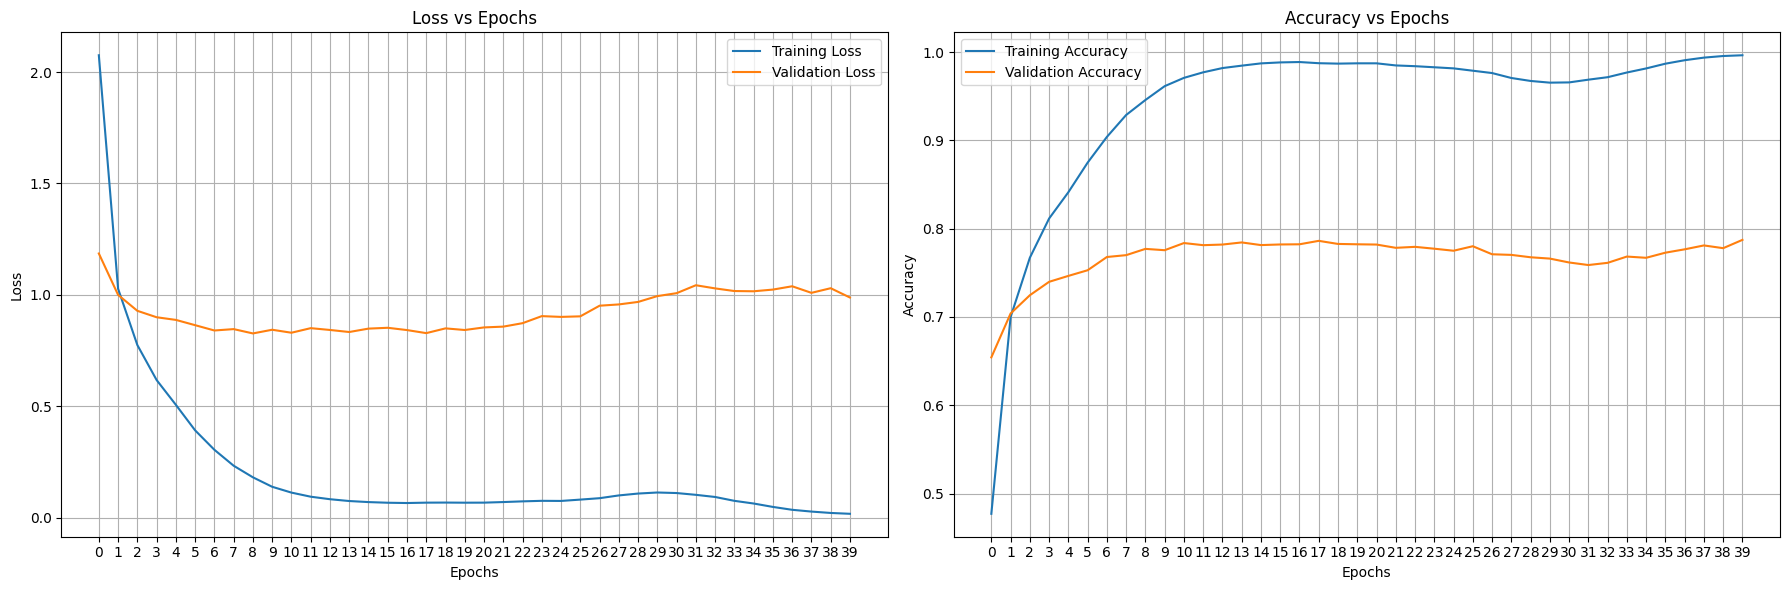

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_losses)), rotation=0)  # Rotate ticks by 20 degrees

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_accuracies)), rotation=0)  # Rotate ticks by 20 degrees

plt.tight_layout()
plt.show()

In [22]:
all_validation_accuracies

[0.6542,
 0.7039,
 0.7246,
 0.7398,
 0.7465,
 0.7529,
 0.7679,
 0.77,
 0.7771,
 0.7756,
 0.7837,
 0.7813,
 0.782,
 0.7844,
 0.7814,
 0.7821,
 0.7823,
 0.7862,
 0.7827,
 0.7823,
 0.782,
 0.7783,
 0.7794,
 0.7773,
 0.775,
 0.7801,
 0.771,
 0.7703,
 0.7676,
 0.7661,
 0.7617,
 0.7588,
 0.7613,
 0.7684,
 0.767,
 0.7728,
 0.7766,
 0.781,
 0.7779,
 0.7873]

In [8]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.77batch/s]

🔍 Test Results:
	📉 Test Loss: 1.0066
	🎯 Test Accuracy: 78.57%
